In [12]:
from __future__ import print_function

In [13]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [14]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [15]:
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [16]:
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver

# Ground truth motor

In [17]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
print(motor)
print(noise_motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 1 0 0.031 0 0.0048 0.005 0.0052 -0.00016 ]


# Dataset

In [18]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

In [19]:
planes_b_noisy = [plane.spin(motor).spin(noise_motor) for plane in planes_a]

# Estimate motor
## No noise

### 4 residuals diff

In [28]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_difference_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_diff_res, summary_planes_diff_res, _) = mes.solve()
print(summary_planes_diff_res['brief_report'])
print(em_planes_diff_res)

Ceres Solver Report: Iterations: 4, Initial cost: 7.079740e+00, Final cost: 1.650210e-20, Termination: CONVERGENCE
Mot: [ 0.87 6.7e-16 -0.5 -5.5e-14 -0.68 -0.43 -0.18 -0.25 ]


In [32]:
np.allclose(em_planes_diff_res, motor)

True

### 4 residuals v

In [35]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_angle_error_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_v_res, summary_planes_v_res, _) = mes.solve()
print(summary_planes_v_res['brief_report'])
print(em_planes_v_res)

Ceres Solver Report: Iterations: 5, Initial cost: 1.410367e+01, Final cost: 1.966713e-16, Termination: CONVERGENCE
Mot: [ 0.87 1.7e-09 -0.5 -6.4e-09 -0.68 -0.43 -0.18 -0.25 ]


In [33]:
np.allclose(em_planes_v_res, motor)

True

### Plots

In [38]:
sns.set_style('whitegrid')
sns.set_context('paper')

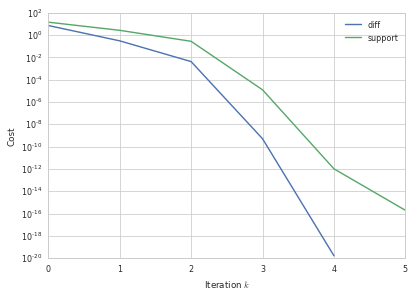

In [41]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_planes_diff_res['iterations'])['cost'], label=r'diff')
ax.plot(pd.DataFrame(summary_planes_v_res['iterations'])['cost'], label=r'support')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('planes-nonoise.pdf')

## Noise

### 4 residuals diff

In [48]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b_noisy):
    mes.add_dual_plane_difference_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_diff_res_noise, summary_planes_diff_res_noise, _) = mes.solve()
print(summary_planes_diff_res_noise['brief_report'])
print(em_planes_diff_res_noise)

Ceres Solver Report: Iterations: 4, Initial cost: 6.757876e+00, Final cost: 3.336436e-21, Termination: CONVERGENCE
Mot: [ 0.88 9.2e-16 -0.47 -2.4e-14 -0.68 -0.44 -0.16 -0.23 ]


### 4 residuals v

In [69]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b_noisy):
    mes.add_dual_plane_angle_error_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_v_res_noise, summary_planes_v_res_noise, _) = mes.solve()
print(summary_planes_v_res_noise['brief_report'])
print(em_planes_v_res_noise)

Ceres Solver Report: Iterations: 5, Initial cost: 1.282907e+01, Final cost: 8.225608e-16, Termination: CONVERGENCE
Mot: [ 0.88 -3.5e-10 -0.47 2.2e-09 -0.68 -0.44 -0.16 -0.23 ]


In [70]:
np.allclose(em_planes_diff_res_noise, em_planes_v_res_noise)

True

### Valkenburg and Dorst

In [53]:
vd = VDMotorEstimationSolver()
vd.add_dual_plane_observations(planes_a, planes_b_noisy)
vd_em_planes_noise = vd.solve()
print(vd_em_planes_noise)

Mot: [ -0.88 2.2e-17 0.47 -1.3e-18 0 0 0 0 ]


In [54]:
vd = VDMotorEstimationSolver()
vd.add_dual_plane_observations(planes_a, planes_b)
vd_em_planes = vd.solve()
print(vd_em_planes)

Mot: [ 0.87 -4.8e-17 -0.5 2.5e-18 0 0 0 0 ]


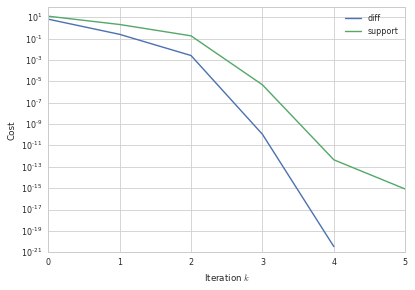

In [68]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_planes_diff_res_noise['iterations'])['cost'], label=r'diff')
ax.plot(pd.DataFrame(summary_planes_v_res_noise['iterations'])['cost'], label=r'support')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
plt.savefig('planes-noise.pdf')

# Visualization

In [72]:
scene = Scene(children=
#               [plane_mesh(plane,color=Colors.HOTPINK) for plane in planes_a[:2]] +\
              [plane_mesh(plane,color=Colors.LIGHTSKYBLUE) for plane in planes_b[:2]] +\
              [plane_mesh(plane,color='palegreen') for plane in planes_b_noisy[:2]] +\
              
#               [plane_mesh(plane.spin(vd_em_planes),color=Colors.HOTPINK) for plane in planes_a[:2]] +\
              [plane_mesh(plane.spin(em_planes_diff_res_noise), color=Colors.HOTPINK) for plane in planes_a[:2]] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
renderer.width = '1024'
renderer.height = '768'
display(renderer)